# Prior Training

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.neighbors import KernelDensity
import pickle

In [2]:
db = ["HAM"]
models = ["RES", "DENSE", "MOBILE"]
root = f"../../dataset/CAI 2025/{db[0]}/"

filepaths = {}
for i in range(len(models)):
    filepaths[models[i]] = f"{root}eval/df_valid_{models[i]}.csv"

df = pd.DataFrame()
for k, v in filepaths.items():
    tmp = pd.read_csv(v)
    tmp["model"] = k
    tmp["db"] = db[0]
    df = pd.concat([df, tmp])

df["accuracy"] = 0
df.loc[df["label"] == df["pred"], "accuracy"] = 1

In [3]:
distances = ["WD", "KUIPER", "AD", "CVM", "KS", "ED"]

Saved: ../../dataset/CAI 2025/HAM/kde/RES_WD.pkl
Saved: ../../dataset/CAI 2025/HAM/kde/RES_KUIPER.pkl
Saved: ../../dataset/CAI 2025/HAM/kde/RES_AD.pkl
Saved: ../../dataset/CAI 2025/HAM/kde/RES_CVM.pkl
Saved: ../../dataset/CAI 2025/HAM/kde/RES_KS.pkl
Saved: ../../dataset/CAI 2025/HAM/kde/RES_ED.pkl
Saved: ../../dataset/CAI 2025/HAM/kde/DENSE_WD.pkl
Saved: ../../dataset/CAI 2025/HAM/kde/DENSE_KUIPER.pkl
Saved: ../../dataset/CAI 2025/HAM/kde/DENSE_AD.pkl
Saved: ../../dataset/CAI 2025/HAM/kde/DENSE_CVM.pkl
Saved: ../../dataset/CAI 2025/HAM/kde/DENSE_KS.pkl
Saved: ../../dataset/CAI 2025/HAM/kde/DENSE_ED.pkl
Saved: ../../dataset/CAI 2025/HAM/kde/MOBILE_WD.pkl
Saved: ../../dataset/CAI 2025/HAM/kde/MOBILE_KUIPER.pkl
Saved: ../../dataset/CAI 2025/HAM/kde/MOBILE_AD.pkl
Saved: ../../dataset/CAI 2025/HAM/kde/MOBILE_CVM.pkl
Saved: ../../dataset/CAI 2025/HAM/kde/MOBILE_KS.pkl
Saved: ../../dataset/CAI 2025/HAM/kde/MOBILE_ED.pkl


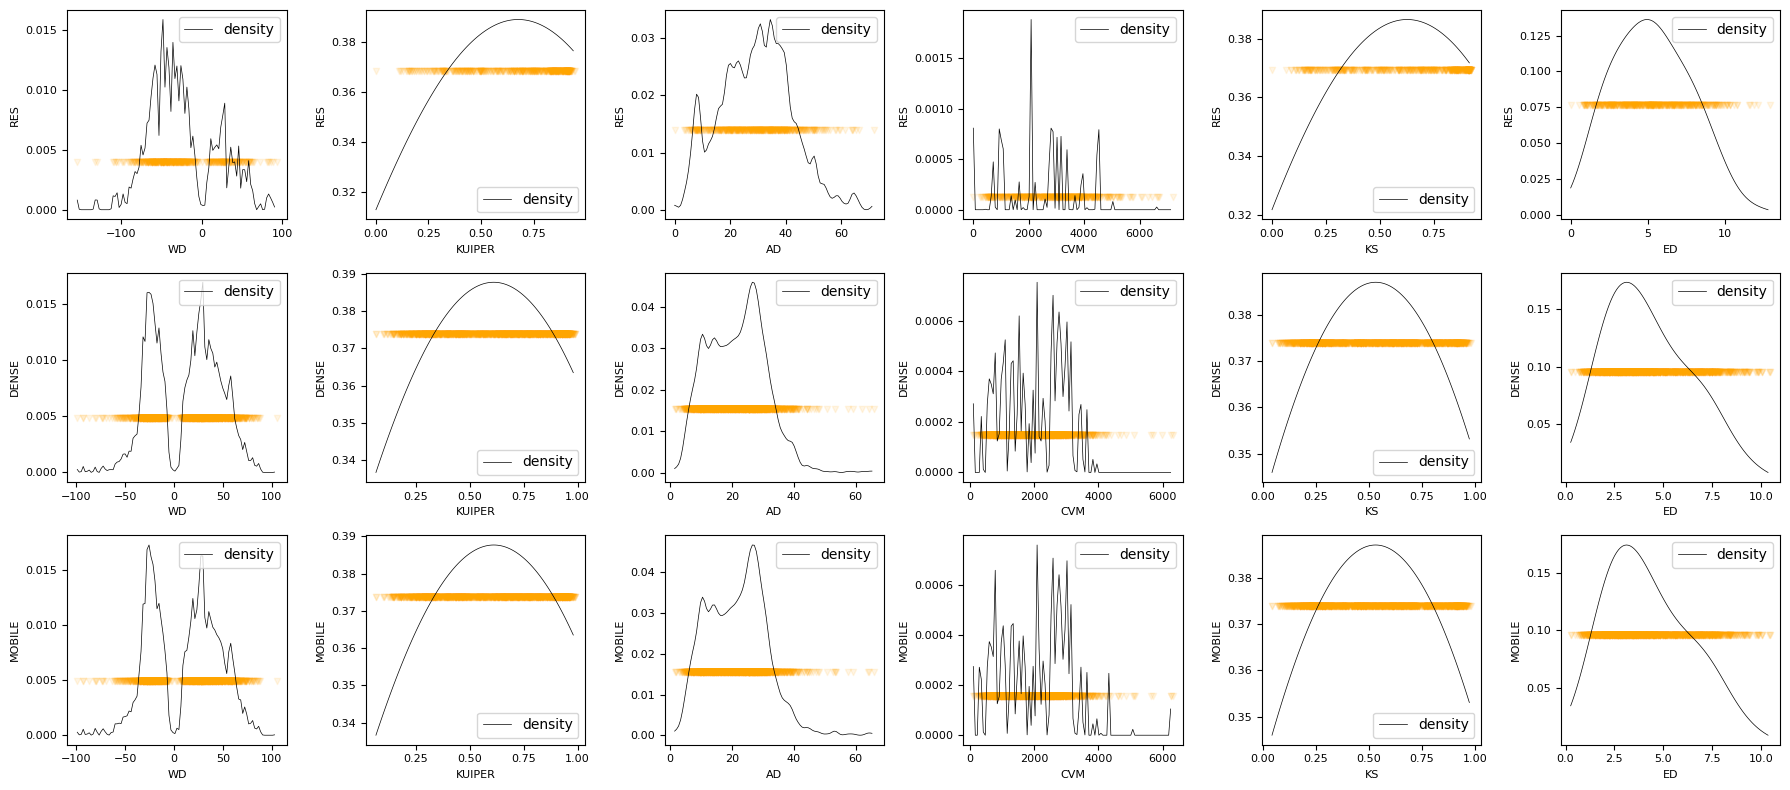

In [11]:
fig, ax = plt.subplots(3, 6, figsize=(18, 8))

for i in range(len(models)):
    for j in range(len(distances)):
        subset = df[(df["db"] == db[0]) & (df["model"] == models[i]) & (df["accuracy"] == 1)]
    
        distance  = distances[j]
        kde = KernelDensity()
        positives = subset[[distance]]
        kde.fit(positives)

        savepath = f"{root}kde/{models[i]}_{distance}.pkl"
        with open(savepath, "wb") as f:
            pickle.dump(kde, f)
            print(f"Saved: {root}kde/{models[i]}_{distance}.pkl")
        
        min_distance = subset[distance].min()
        max_distance = subset[distance].max()
        diff = max_distance - min_distance
        
        # plot用X座標の値を生成
        num_samples = 100
        X = pd.DataFrame({distance:min_distance + (np.arange(num_samples) / num_samples) * diff})
        
        # 各X座標の確率値を取得
        dists = kde.score_samples(X)
        df_for_plot = X.copy()
        df_for_plot["density"] = np.exp(dists)
        
        # KDEで求めた分布を表示
        ax[i, j] = df_for_plot.plot(kind="line", x=distance, y="density", ax=ax[i, j], linewidth=0.5, fontsize=8, color="black")
        # データ位置に点を打つ
        positives_for_plot = positives.copy()
        positives_for_plot["x"] = df_for_plot["density"].mean()
        positives_for_plot.plot(kind="scatter", x=distance, y="x", marker="v", alpha=0.1, ax=ax[i, j], color="orange")
        
        ax[i, j].set_ylabel(f"{models[i]}", fontsize=8)
        ax[i, j].set_xlabel(distance, fontsize=8)

plt.tight_layout()
plt.show()

In [5]:
subset = df[(df["db"] == db[0]) & (df["model"] == models[i])]
len(subset)

2002

In [6]:
subset = df[(df["db"] == db[0]) & (df["model"] == models[i])]
distance  = "AD"
num_samples = 10
strata = pd.qcut(subset[distance], q=10, retbins=False)  # KDEに基づいた

In [7]:
strata

0       (20.013, 23.237]
1        (28.168, 30.68]
2        (9.656, 13.076]
3       (16.545, 20.013]
4       (13.076, 16.545]
              ...       
1997     (28.168, 30.68]
1998    (34.671, 67.445]
1999     (9.656, 13.076]
2000     (9.656, 13.076]
2001    (34.671, 67.445]
Name: AD, Length: 2002, dtype: category
Categories (10, interval[float64, right]): [(-0.001, 9.656] < (9.656, 13.076] < (13.076, 16.545] < (16.545, 20.013] ... (25.786, 28.168] < (28.168, 30.68] < (30.68, 34.671] < (34.671, 67.445]]

In [31]:
strata.cat.categories

IntervalIndex([(-0.001, 9.656], (9.656, 13.076], (13.076, 16.545], (16.545, 20.013], (20.013, 23.237], (23.237, 25.786], (25.786, 28.168], (28.168, 30.68], (30.68, 34.671], (34.671, 67.445]], dtype='interval[float64, right]')

In [32]:
stratum_samples = []

for stratum in strata.cat.categories:
    stratum_data = subset[strata == stratum]
    sampled = stratum_data.sample(n=num_samples, replace=True)
    stratum_samples.append(sampled)

# サンプルデータの結合
stratified_sample = pd.concat(stratum_samples)

In [33]:
stratified_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 500 to 1176
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lesion_id      100 non-null    object 
 1   image_id       100 non-null    object 
 2   dx             100 non-null    object 
 3   dx_type        100 non-null    object 
 4   age            98 non-null     float64
 5   sex            100 non-null    object 
 6   localization   100 non-null    object 
 7   filename       100 non-null    object 
 8   filepath       100 non-null    object 
 9   filepath_seg   100 non-null    object 
 10  filepath_mask  100 non-null    object 
 11  label          100 non-null    int64  
 12  means          100 non-null    float64
 13  WD             100 non-null    float64
 14  KUIPER         100 non-null    float64
 15  AD             100 non-null    float64
 16  CVM            100 non-null    float64
 17  KS             100 non-null    float64
 18  ED          

In [34]:
stratified_sample[["AD", "accuracy"]].corr()

,AD,accuracy
AD,1.000000,-0.175184
accuracy,-0.175184,1.000000
